In [1]:
import sys
sys.path.append('..')
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [98]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import MultivariateNormal
from catboost import CatBoostClassifier
from scipy.special import logsumexp

from src.nf import FCNN

import matplotlib.pyplot as plt
from IPython.display import clear_output
import xgboost as xgb

%matplotlib inline

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
! nvidia-smi

Sat May  2 17:27:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00001441:00:00.0 Off |                    0 |
| N/A   61C    P8    30W / 149W |     11MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           On   | 00003533:00:00.0 Off |                    0 |
| N/A   50C    P0    71W / 149W |   1046MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [64]:
def ohe(arr, s, return_tensor=False):
    res = np.zeros((arr.size, s), dtype=np.float32)
    res[np.arange(arr.size), arr] = 1
    if not return_tensor:
        return res
    else:
        return torch.from_numpy(res.astype(np.float32)).to(device)

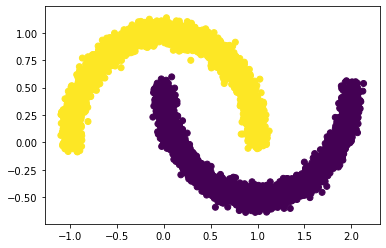

In [6]:
X, Y = make_moons(10000)
Y = ohe(Y, 2).astype(np.float32)
n, dim, cond_dim = X.shape[0], X.shape[1], Y.shape[1]
X += np.random.normal(0, 0.05, X.shape)
X = X.astype(np.float32)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train[:, 0])

In [7]:
X_train_tensor = torch.from_numpy(X_train).to(device)
X_test_tensor = torch.from_numpy(X_test).to(device)
Y_train_tensor = torch.from_numpy(Y_train).to(device)
Y_test_tensor = torch.from_numpy(Y_test).to(device)

In [17]:
class ConditionalNormalizingFlowModel(nn.Module):

    def __init__(self, dim, condition_dim, prior, flows, mu=FCNN, log_sigma=FCNN, hidden_dim=8):
        super().__init__()
        self.dim = dim
        self.condition_dim = condition_dim
        self.prior = prior
        self.flows = nn.ModuleList(flows)
        self.mu = mu(condition_dim, dim, hidden_dim)
        self.log_sigma = log_sigma(condition_dim, dim, hidden_dim)

    def forward(self, x, condition):
        m, _ = x.shape
        log_det = torch.zeros(m).to(x.device)
        for flow in self.flows:
            if hasattr(flow, 'is_conditional'):
                x, ld = flow.forward(x, condition)
            else:
                x, ld = flow.forward(x)
            log_det += ld
        
        mu, log_sigma = self.mu(condition), self.log_sigma(condition)
        x = (x - mu) * torch.exp(-log_sigma)
        log_det -= log_sigma.sum(dim=1)
        z, prior_logprob = x, self.prior.log_prob(x)
        return z, prior_logprob, log_det

    def backward(self, z, condition):
        m, _ = z.shape
        log_det = torch.zeros(m).to(z.device)
        mu, log_sigma = self.mu(condition), self.log_sigma(condition)
        z = z * torch.exp(log_sigma) + mu
        log_det += log_sigma.sum(dim=1)
        for flow in self.flows[::-1]:
            if hasattr(flow, 'is_conditional'):
                z, ld = flow.backward(z, condition)
            else:
                z, ld = flow.backward(z)
            log_det += ld
        x = z
        return x, log_det

In [18]:
class ConditionalMAF(nn.Module):
    def __init__(self, dim, cond_dim, hidden_dim=8, base_network=FCNN):
        super().__init__()
        self.dim = dim
        self.layers = nn.ModuleList()
        self.initial_param = nn.Parameter(torch.Tensor(2))
        for i in range(1, dim):
            self.layers += [base_network(i + cond_dim, 2, hidden_dim)]
        self.reset_parameters()
    
    @staticmethod
    def is_conditional():
        return True

    def reset_parameters(self):
        nn.init.uniform_(self.initial_param, -np.sqrt(0.5), np.sqrt(0.5))

    def forward(self, x, condition):
        z = torch.zeros_like(x)
        log_det = torch.zeros(z.shape[0]).to(x.device)
        for i in range(self.dim):
            if i == 0:
                mu, alpha = self.initial_param[0], self.initial_param[1]
            else:
                out = self.layers[i - 1](torch.cat([x[:, :i], condition], axis=1))
                mu, alpha = out[:, 0], out[:, 1]
            z[:, i] = (x[:, i] - mu) / torch.exp(alpha)
            log_det -= alpha
        return z.flip(dims=(1,)), log_det

    def backward(self, z, condition):
        x = torch.zeros_like(z)
        log_det = torch.zeros(z.shape[0]).to(z.device)
        z = z.flip(dims=(1,))
        for i in range(self.dim):
            if i == 0:
                mu, alpha = self.initial_param[0], self.initial_param[1]
            else:
                out = self.layers[i - 1](torch.cat([x[:, :i], condition], axis=1))
                mu, alpha = out[:, 0], out[:, 1]
            x[:, i] = mu + torch.exp(alpha) * z[:, i]
            log_det += alpha
        return x, log_det

In [55]:
flows = []
for i in range(2):
    flows.append(ConditionalMAF(dim, cond_dim).to(device))

prior = MultivariateNormal(torch.zeros(dim).to(device), torch.eye(dim).to(device))
model = ConditionalNormalizingFlowModel(dim, cond_dim, prior, flows).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [56]:
epoches = 301
metrics_ll_train, metrics_ll_test = [], []

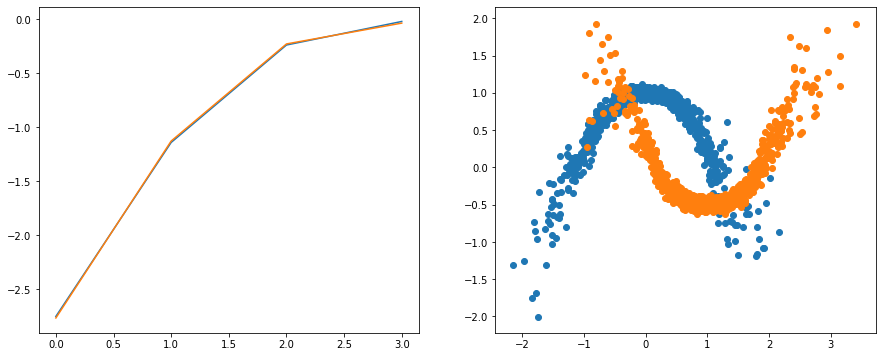

In [57]:
for i in range(len(metrics_ll_train), epoches):
    model.train()
    optimizer.zero_grad()
    z, logp_z, log_det = model(X_train_tensor, Y_train_tensor)
    logp_x = logp_z + log_det
    loss = -torch.mean(logp_x)
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        model.eval()
        with torch.no_grad():
            _, logp_z, log_det = model(X_train_tensor, Y_train_tensor)
            metrics_ll_train.append(torch.mean(logp_z + log_det).item())
            _, logp_z, log_det = model(X_test_tensor, Y_test_tensor)
            metrics_ll_test.append(torch.mean(logp_z + log_det).item())
            
            z = prior.sample_n(1000)
            samples_1, _ = model.backward(z, ohe(np.zeros(z.shape[0], dtype=np.uint32), 2, True))
            samples_1 = samples_1.detach().cpu().numpy()
            samples_2, _ = model.backward(z, ohe(np.ones(z.shape[0], dtype=np.uint32), 2, True))
            samples_2 = samples_2.detach().cpu().numpy()

        clear_output(False)
        fig, axs = plt.subplots(1, 2, figsize=(15, 6))
        
        axs[0].plot(metrics_ll_train)
        axs[0].plot(metrics_ll_test)
        
        axs[1].scatter(samples_1[:, 0], samples_1[:, 1])
        axs[1].scatter(samples_2[:, 0], samples_2[:, 1])
        plt.show()

In [79]:
real_data = np.hstack([X_train, Y_train])

model.eval()
with torch.no_grad():
    z = prior.sample_n(real_data.shape[0] // 2)
    samples_0, _ = model.backward(z, ohe(np.zeros(z.shape[0], dtype=np.uint32), 2, True))
    samples_0 = samples_0.detach().cpu().numpy()

    gen_data_0 = np.hstack([
        samples_0,
        ohe(np.zeros(z.shape[0], dtype=np.uint32), 2)
    ])
    
    samples_1, _ = model.backward(z, ohe(np.ones(z.shape[0], dtype=np.uint32), 2, True))
    samples_1 = samples_1.detach().cpu().numpy()

    gen_data_1 = np.hstack([
        samples_1,
        ohe(np.ones(z.shape[0], dtype=np.uint32), 2)
    ])

X_clf = np.vstack([real_data, gen_data_0, gen_data_1])
Y_clf = np.hstack([np.ones(real_data.shape[0]), np.zeros(real_data.shape[0])])

X_train_clf, X_test_clf, Y_train_clf, Y_test_clf = train_test_split(X_clf, Y_clf, test_size=0.2)

In [83]:
X_clf.shape

(16000, 4)

In [84]:
clf = CatBoostClassifier(
    100, eval_metric='AUC',
    metric_period=10,
    use_best_model=False
).fit(
    X_train_clf, Y_train_clf,
    eval_set=(X_test_clf, Y_test_clf)
)

Learning rate set to 0.252763
0:	test: 0.6664482	best: 0.6664482 (0)	total: 18.7ms	remaining: 1.85s
10:	test: 0.6862156	best: 0.6862156 (10)	total: 180ms	remaining: 1.45s
20:	test: 0.6895918	best: 0.6895918 (20)	total: 353ms	remaining: 1.33s
30:	test: 0.6920110	best: 0.6920110 (30)	total: 475ms	remaining: 1.06s
40:	test: 0.6946916	best: 0.6946916 (40)	total: 629ms	remaining: 905ms
50:	test: 0.6965481	best: 0.6965481 (50)	total: 785ms	remaining: 754ms
60:	test: 0.6993694	best: 0.6993694 (60)	total: 935ms	remaining: 598ms
70:	test: 0.6995493	best: 0.6995493 (70)	total: 1.08s	remaining: 440ms
80:	test: 0.6991932	best: 0.6995493 (70)	total: 1.24s	remaining: 290ms
90:	test: 0.6988257	best: 0.6995493 (70)	total: 1.39s	remaining: 138ms
99:	test: 0.6991279	best: 0.6995493 (70)	total: 1.53s	remaining: 0us

bestTest = 0.6995492789
bestIteration = 70



In [105]:
calibration_constant_0 = logsumexp(clf.predict(gen_data_0, prediction_type='RawFormulaVal'))
calibration_constant_1 = logsumexp(clf.predict(gen_data_1, prediction_type='RawFormulaVal'))

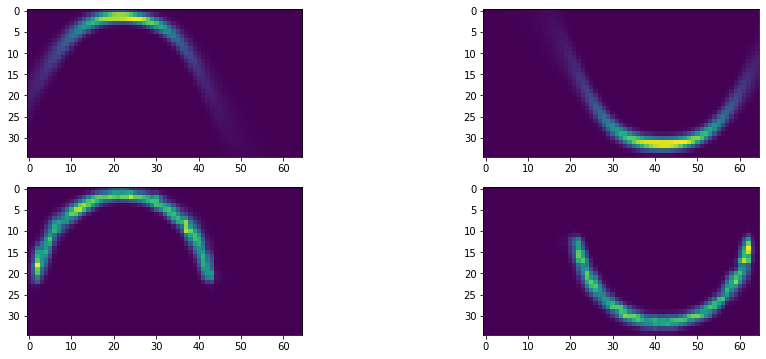

In [106]:
X_val = np.transpose(np.dstack(np.meshgrid(
        np.arange(np.min(X_test[:, 0]), np.max(X_test[:, 0]), 0.05),
        np.arange(np.min(X_test[:, 1]), np.max(X_test[:, 1]), 0.05),
    )), axes=[1, 0, 2]).astype(np.float32)

logits_1 = clf.predict(
    np.hstack([X_val.reshape(-1, 2), ohe(np.ones(X_val.reshape(-1, 2).shape[0], dtype=np.uint8), 2)]),
    prediction_type='RawFormulaVal'
)
logits_0 = clf.predict(
    np.hstack([X_val.reshape(-1, 2), ohe(np.zeros(X_val.reshape(-1, 2).shape[0], dtype=np.uint8), 2)]),
    prediction_type='RawFormulaVal'
)

model.eval()
with torch.no_grad():
    _, logp_z, log_det = model(
        torch.from_numpy(
            X_val.reshape(-1, 2),
        ).to(device),
        ohe(np.zeros(X_val.reshape(-1, 2).shape[0], dtype=np.uint8), 2, True)
    )
    log_probs_0 = logp_z + log_det
    log_probs_0 = log_probs_0.detach().cpu().numpy()
    probs_0 = np.exp(log_probs_0).reshape(X_val.shape[0], X_val.shape[1])
    probs_0_fixed = np.exp(log_probs_0 + logits_0 - calibration_constant_0).reshape(X_val.shape[0], X_val.shape[1])

    _, logp_z, log_det = model(
        torch.from_numpy(
            X_val.reshape(-1, 2),
        ).to(device),
        ohe(np.ones(X_val.reshape(-1, 2).shape[0], dtype=np.uint8), 2, True)
    )
    log_probs_1 = logp_z + log_det
    log_probs_1 = log_probs_1.detach().cpu().numpy()
    probs_1 = np.exp(log_probs_1).reshape(X_val.shape[0], X_val.shape[1])
    probs_1_fixed = np.exp(log_probs_1 + logits_1 - calibration_constant_1).reshape(X_val.shape[0], X_val.shape[1])
    

fig, axs = plt.subplots(2, 2, figsize=(15, 6))

axs[0, 0].imshow(probs_0.T[::-1])
axs[0, 1].imshow(probs_1.T[::-1])

axs[1, 0].imshow(probs_0_fixed.T[::-1])
axs[1, 1].imshow(probs_1_fixed.T[::-1])